In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
from transformers import EsmModel, EsmTokenizer
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !pip install scikit-learn

In [4]:
# Load dataset
data_path = './augmented_dataset_with_estimates.csv'
data = pd.read_csv(data_path)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# ----------------- Step 1: Feature Extraction -----------------
# Protein Embeddings using ESM
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

embedding_dim = model.config.hidden_size

def get_protein_embedding(uniprot_id):
    """Compute embeddings for protein sequences using ESM model."""
    inputs = tokenizer(uniprot_id, return_tensors="pt", add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling over sequence tokens
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

# Generate embeddings for proteins
protein_embeddings = {}
for uniprot_id in data['UniProt_ID'].unique():
    try:
        protein_embeddings[uniprot_id] = get_protein_embedding(uniprot_id)
    except Exception as e:
        print(f"Error for {uniprot_id}: {e}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# ----------------- Step 2: Placeholder Chemical Features -----------------
# Generate random embeddings for chemicals
def generate_random_projections(cids, embedding_dim=embedding_dim):
    """Generate random embeddings using SparseRandomProjection."""
    random_projector = SparseRandomProjection(n_components=embedding_dim, random_state=42)
    cid_indices = {cid: idx for idx, cid in enumerate(cids)}
    random_matrix = np.random.rand(len(cids), embedding_dim)
    random_embeddings = random_projector.fit_transform(random_matrix)
    return {cid: random_embeddings[cid_indices[cid]] for cid in cids}


unique_cids = data['pubchem_cid'].dropna().unique()

chemical_embeddings = generate_random_projections(unique_cids)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.softmax = nn.Softmax(dim=1)  # Apply softmax over the sequence dimension

    def forward(self, x):
        # Compute attention weights
        attention_weights = self.softmax(self.attention(x))
        # Apply weights and maintain embedding dimension
        weighted_output = x * attention_weights
        return weighted_output.sum(dim=1)  # Collapse sequence dimension, retain batch size and embedding dim

In [9]:
# ----------------- Step 4: Dataset Preparation -----------------
class BindingDataset(Dataset):
    def __init__(self, data, protein_embeddings, chemical_embeddings):
        self.data = data
        self.protein_embeddings = protein_embeddings
        self.chemical_embeddings = chemical_embeddings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        protein_emb = self.protein_embeddings[row['UniProt_ID']]  # Shape: (embedding_dim,)
        chemical_emb = self.chemical_embeddings[row['pubchem_cid']]  # Shape: (embedding_dim,)
        label = row['binding']
        weight = 0.5 if row['kiba_score_estimated'] else 1.0

        return (torch.tensor(protein_emb, dtype=torch.float32).unsqueeze(0),  # Add batch dimension
                torch.tensor(chemical_emb, dtype=torch.float32).unsqueeze(0),  # Add batch dimension
                torch.tensor(label, dtype=torch.float32),
                torch.tensor(weight, dtype=torch.float32))

In [10]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = BindingDataset(train_data, protein_embeddings, chemical_embeddings)
test_dataset = BindingDataset(test_data, protein_embeddings, chemical_embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
# ----------------- Step 5: Deep Learning Model -----------------
class BindingPredictor(nn.Module):
    def __init__(self, embedding_dim):
        super(BindingPredictor, self).__init__()
        self.protein_attention = AttentionBlock(embedding_dim)
        self.chemical_attention = AttentionBlock(embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)#,
            # nn.Sigmoid()
        )

    def forward(self, protein_emb, chemical_emb):
        protein_feat = self.protein_attention(protein_emb)  # Shape: (batch_size, embedding_dim)
        chemical_feat = self.chemical_attention(chemical_emb)  # Shape: (batch_size, embedding_dim)
        combined = torch.cat((protein_feat, chemical_feat), dim=1)  # Concatenate along embedding dimension
        return self.fc(combined)

In [12]:
# Initialize model
model = BindingPredictor(embedding_dim)
model = model.to(device)
# Loss and optimizer
# criterion = nn.BCELoss(reduction='none')
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = Adam(model.parameters(), lr=1e-4)

In [13]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for protein_emb, chemical_emb, labels, weights in train_loader:
            protein_emb, chemical_emb, labels, weights = (
                protein_emb.to(device),
                chemical_emb.to(device),
                labels.to(device),
                weights.to(device),
            )
            optimizer.zero_grad()
            outputs = model(protein_emb, chemical_emb).squeeze()
            loss = (criterion(outputs, labels) * weights).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

In [15]:
# Train and evaluate
train_model(model, train_loader, criterion, optimizer, device)

Epoch 1/10, Loss: 18595.2393
Epoch 2/10, Loss: 18416.5322
Epoch 3/10, Loss: 18261.9164
Epoch 4/10, Loss: 18123.1783
Epoch 5/10, Loss: 18012.8385
Epoch 6/10, Loss: 17923.9623
Epoch 7/10, Loss: 17851.1420
Epoch 8/10, Loss: 17791.4888
Epoch 9/10, Loss: 17741.9351
Epoch 10/10, Loss: 17698.5198


UnboundLocalError: local variable 'weights' referenced before assignment

In [16]:
torch.save(model.state_dict(), 'classification_model.pth')

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for protein_emb, chemical_emb, labels, _ in test_loader:
            # Move data to the specified device
            protein_emb, chemical_emb, labels = (
                protein_emb.to(device),
                chemical_emb.to(device),
                labels.to(device),
            )
            outputs = model(protein_emb, chemical_emb).squeeze()
            predictions = (outputs > 0.5).float()
            
            # Collect predictions and true labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Binding", "Binding"], yticklabels=["No Binding", "Binding"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    print(f"Test Accuracy: {accuracy:.4f}")

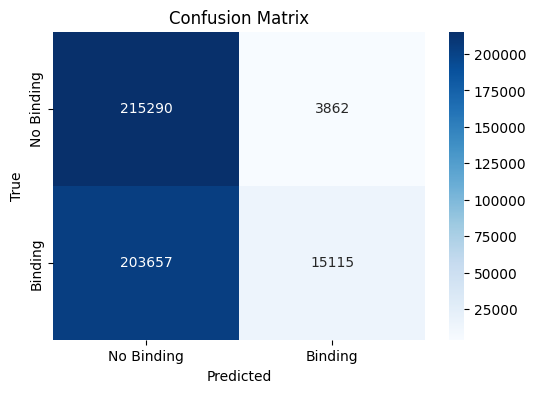

Test Accuracy: 0.5261


In [25]:
evaluate_model(model, test_loader, device)